# **Import Dependencies¶**


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import random
import cv2

!pip install tensorflow
import tensorflow as tf
import keras
from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')



# **Define Data Path¶**


In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Alzheimer-MRI/MRI_Data/Dataset'


Mounted at /content/drive


In [3]:
classes = os.listdir(data_path)
#classes

# **Visualize the classes**

In [4]:
def display_samples(path, columns=5, rows=2):
    fig=plt.figure(figsize=(3*columns, 3*rows))
    title = path.split('/')[-1]
    for i in range(columns*rows):
        image = cv2.imread(path +'/'+ random.choice(sorted(os.listdir(path))))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #plt.subplot(rows, columns, i+1)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title(title, fontsize=15, color='blue')

    #plt.tight_layout()
#display_samples(data_path + '/' + classes[0])

**We see here some images with grayscale and others with rgb**

In [5]:
#display_samples(data_path + '/' + classes[1])

In [6]:
#display_samples(data_path + '/' + classes[2])

In [7]:
#for i in range(9, 44):
#  display_samples(data_path + '/' + classes[i])

In [8]:
def main(train_data_path):



    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)

        train_df = obtain_train_df(filepaths, labels)


    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):


    for s_class in classes_list:

        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))

        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)

    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):

    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)


def obtain_train_df(filepaths, labels):

    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

In [9]:
data_df = main(data_path)

In [10]:
data_df.head()

image_path             label
0  /content/drive/My Drive/Alzheimer-MRI/MRI_Data...  Mild_Demented T1
1  /content/drive/My Drive/Alzheimer-MRI/MRI_Data...  Mild_Demented T1
2  /content/drive/My Drive/Alzheimer-MRI/MRI_Data...  Mild_Demented T1
3  /content/drive/My Drive/Alzheimer-MRI/MRI_Data...  Mild_Demented T1
4  /content/drive/My Drive/Alzheimer-MRI/MRI_Data...  Mild_Demented T1

In [11]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 4 classes
We have 6400 images


In [12]:
#data_df['label'].value_counts()

In [13]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

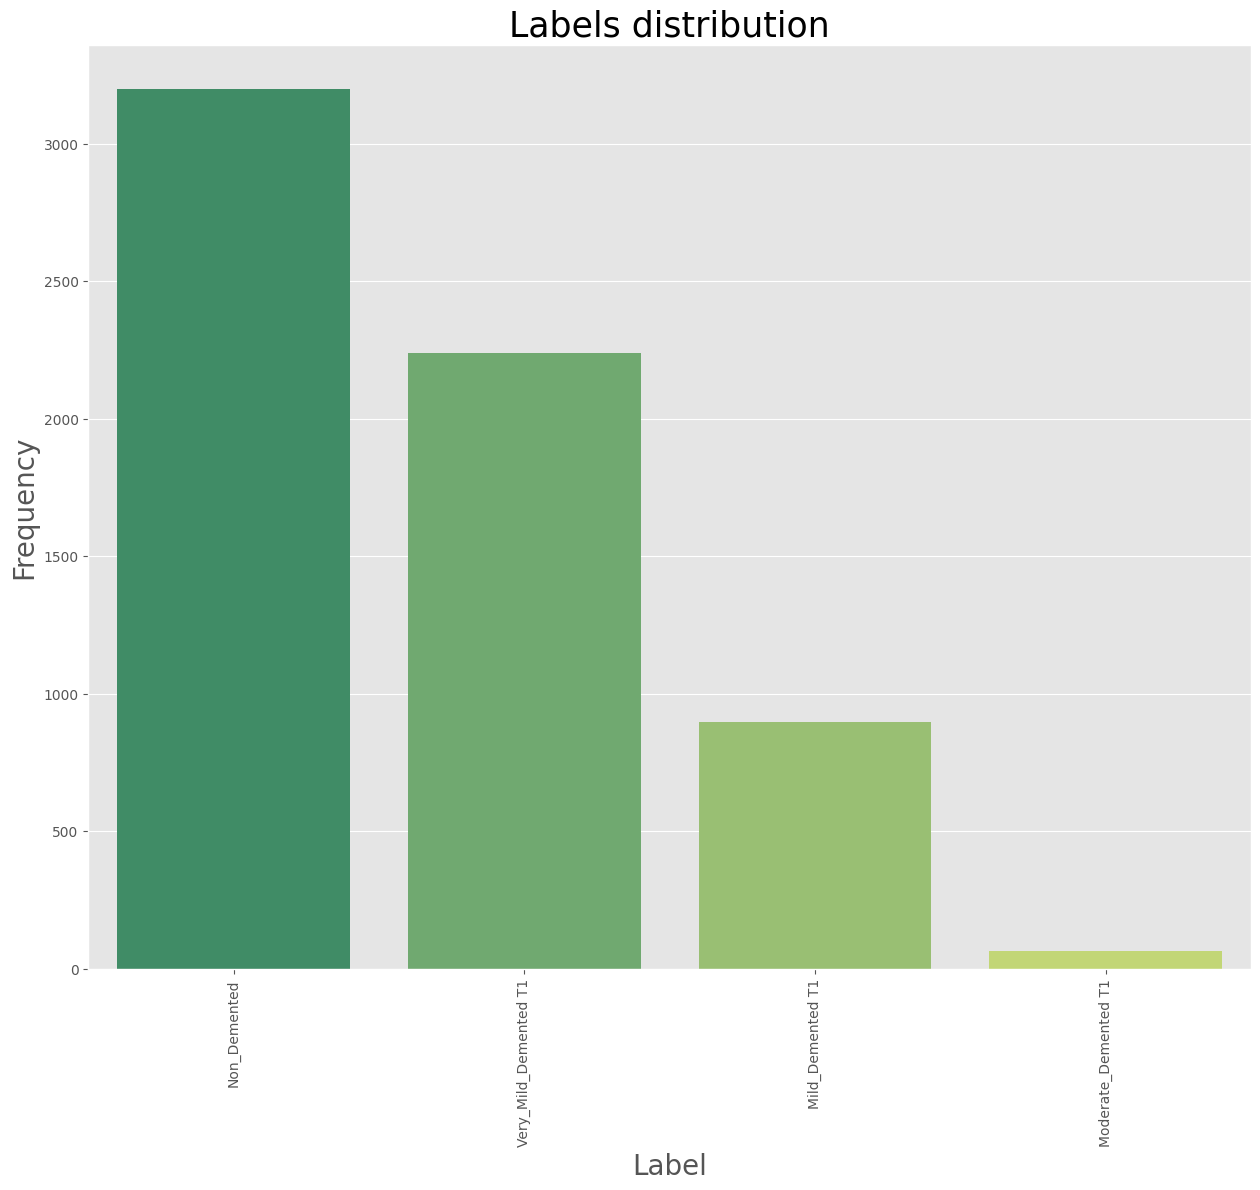

In [14]:
x = data_df['label']
order = x.value_counts().index
count_plot(x, "Labels distribution", "Label", 'Frequency', 15,12, rotation = True, order=order, palette='summer')

**Data is imbalanced**

# **Split the data into train, test and val dataframes**

In [15]:
# Generate data paths with labels
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            # Select just tumor name
            fold = str(fold).replace('C+', '')
            labels.append(fold[:-3])

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [16]:
# Function that contain only a directory of data and it is not splitted
def tr_ts_data(tr_dir, ts_dir):
    # train and valid dataframe
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # test dataframe
    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

# Function that contain train and test directory of data.
def full_data(data_dir):
    # train dataframe: 80% for training
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe: 10% for validation and 10% for test
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df


# function that contain the three directory of data train, valid, and test
def tr_val_ts_data(tr_dir, val_dir, ts_dir):

    # train dataframe
    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    # validation dataframe
    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    # test dataframe
    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

In [17]:
def split_data(tr_dir, val_dir=None, ts_dir=None):

    # No Validation or Test data
    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    # No Validation data
    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    # All data existed
    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

# **Define the data generator for training, validating and testing**


In [18]:
def create_model_data (train_df, valid_df, test_df, batch_size):


    # define model parameters
    img_size = (224, 224)  #resize the orginal image shape to 224x224
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                                horizontal_flip= True)

    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df,
                                           x_col= 'filepaths',
                                           y_col= 'labels',
                                           target_size= img_size,
                                           class_mode= 'categorical',
                                           color_mode= color,
                                           shuffle= True,
                                           batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df,
                                           x_col= 'filepaths',
                                           y_col= 'labels',
                                           target_size= img_size,
                                           class_mode= 'categorical',
                                           color_mode= color,
                                           shuffle= True,
                                           batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df,
                                          x_col= 'filepaths',
                                          y_col= 'labels',
                                          target_size= img_size,
                                          class_mode= 'categorical',
                                          color_mode= color,
                                          shuffle= False,
                                          batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

# **Plot Images for all classes**

In [19]:
def show_images(gen):

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()



In [20]:
def plot_label_count(df, plot_title):
 
    # Define needed variables
    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(x=labels, y=values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

In [21]:
train_dir = data_path
#valid_dir = input('Enter validation data directory (if no valid dir press Enter): ')
#test_dir = input('Enter test data directory (if no test dir press Enter): ')
valid_dir = ''
test_dir = ''
    # Get splitted data
train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)

    # Get Generators
batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

Found 5120 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.
Found 640 validated image filenames belonging to 4 classes.


In [22]:
#show_images(train_gen)

In [23]:
train_df.shape

(5120, 2)

In [24]:
test_df.shape

(640, 2)

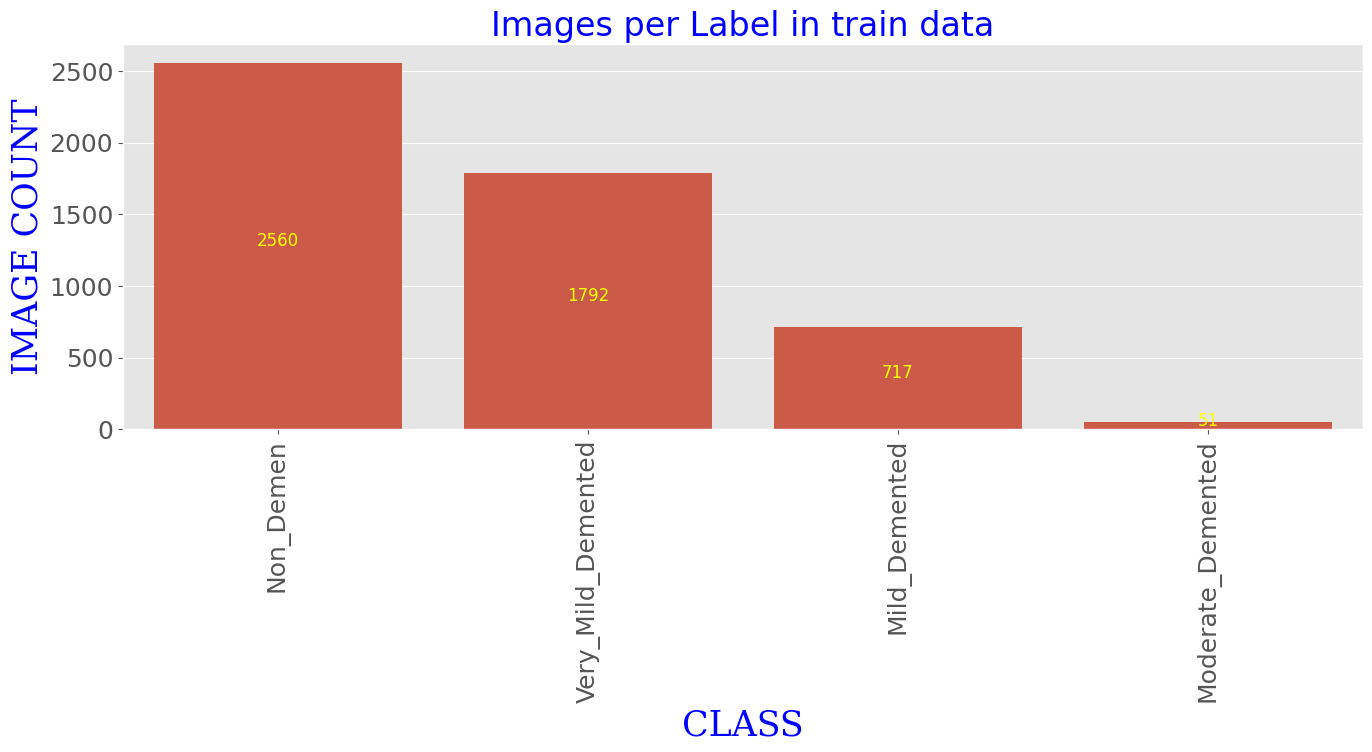

In [25]:
plot_label_count(train_df, 'train')

# **Load EfficientNetV2B3 Pre-trained Model**

In [26]:

# Import the EfficientNetV2B3 model pre-trained on ImageNet without the top layers
base_model = tf.keras.applications.EfficientNetV2B3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model layers to prevent them from being trained
base_model.trainable = True  #Unfreeze Some Layers for Fine-Tuning

#fine_tune_at = len(base_model.layers) - 20
#for layer in base_model.layers[:fine_tune_at]:
#    layer.trainable = False

# Create  model
keras_model = keras.models.Sequential()
keras_model.add(tf.keras.Input(shape=(224, 224, 3)))
keras_model.add(base_model)
keras_model.add(keras.layers.GlobalAveragePooling2D())  # Replace Flatten with GlobalAveragePooling
keras_model.add(keras.layers.BatchNormalization())  # Add a Batch Normalization Layer
keras_model.add(keras.layers.Dense(128, activation='relu'))  # Increase the Model Capacity
keras_model.add(keras.layers.Dropout(0.3))  # Reduce Regularization
keras_model.add(keras.layers.Dense(4, activation=tf.nn.softmax))  # 18 output units for classification

# Display the model's architecture
keras_model.summary()

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b3 (Functional)       │ (None, 7, 7, 1536)          │      12,930,622 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1536)                │           6,144 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         196,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,134,018 (50.10 MB)

 Trainable params: 13,021,730 (49.67 MB)

 Non-trainable params: 112,288 (438.62 KB)

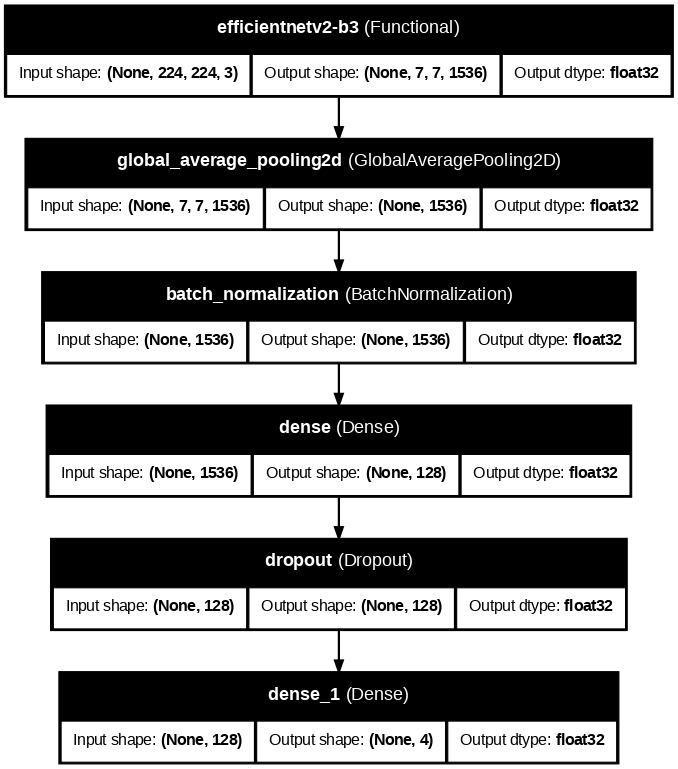

In [27]:
# Plot EfficientNetV2M model
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=80)

In [28]:
# Define a checkpoint callback to save the best model

#save_weights_only=True in ModelCheckpoint, the filepath provided must end in .weights.h5 (Keras weights format)
# Set up ModelCheckpoint callback
def checkpoint_callback():
    checkpoint_filepath = '/content/drive/MyDrive/Alzheimer-MRI/MRI_Data/model/best_model_weights.weights.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=True,  # Save only the best weights
                           monitor='val_accuracy',
                           mode = 'max',          # 'max' because we are looking for max validation acc
                           save_best_only=True,
                           verbose=1)
    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
    return es_callback

class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the current learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        # If the learning rate is a schedule, evaluate it
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        #print(f"Epoch {epoch + 1}: Learning rate is {lr.numpy()}")
        print(f"  Learning rate: {lr.numpy()}")

def step_decay(epoch):
    initial_learning_rate = 0.001
    drop = 0.5  # The factor by which to drop the learning rate
    epochs_drop = 10  # Drop the learning rate after every 10 epochs
    lr = initial_learning_rate * (drop ** (epoch // epochs_drop))
    print(f"  Learning rate: {lr}")
    return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=10)

callbacks = [lr_scheduler, checkpoint_callback, early_stopping]

#Create the Adam optimizer with an initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Use initial learning rate here

keras_model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])



ModelCheckpoint
Callback to save the Keras model or model weights at some frequency.
ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

EarlyStopping
Stop training when a monitored metric has stopped improving..

In [29]:
#history = keras_model.fit(train_gen,epochs=50,batch_size=32, validation_data=valid_gen,callbacks= callbacks, class_weight = class_weights)
hist = keras_model.fit(train_gen,epochs=50,batch_size=32, validation_data=valid_gen,callbacks= callbacks)

  Learning rate: 0.001
Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.4696 - loss: 1.5216
Epoch 1: val_accuracy improved from -inf to 0.51250, saving model to /content/drive/MyDrive/Alzheimer-MRI/MRI_Data/model/best_model_weights.weights.h5
160/160 ━━━━━━━━━━━━━━━━━━━━ 1670s 9s/step - accuracy: 0.4698 - loss: 1.5202 - val_accuracy: 0.5125 - val_loss: 1.0302 - learning_rate: 0.0010
  Learning rate: 0.001
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.5523 - loss: 1.1574
Epoch 2: val_accuracy did not improve from 0.51250
160/160 ━━━━━━━━━━━━━━━━━━━━ 78s 239ms/step - accuracy: 0.5524 - loss: 1.1574 - val_accuracy: 0.4266 - val_loss: 1.1710 - learning_rate: 0.0010
  Learning rate: 0.001
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5259 - loss: 1.2647
Epoch 3: val_accuracy improved from 0.51250 to 0.59688, saving model to /content/drive/MyDrive/Alzheimer-MRI/MRI_Data/model/best_model_weights.weights.h5
160/160 ━━━━━━━━━━━━━━━━━━━

In [30]:
# Function to get true and predicted labels from the dataset
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()



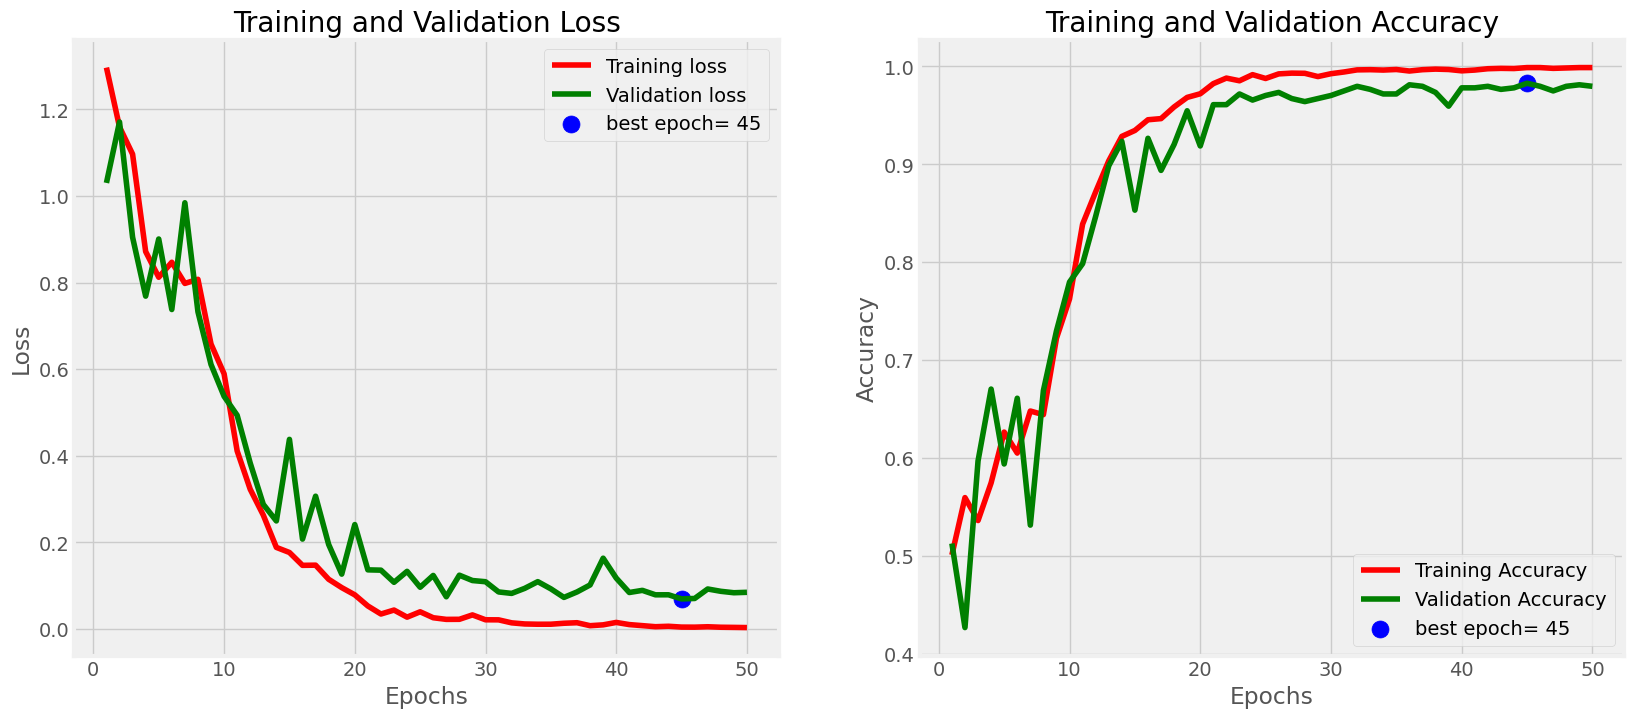

In [31]:
plot_training(hist)

Evaluate on testing **dataset**

In [32]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = keras_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = keras_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = keras_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 3.4452e-05
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9901 - loss: 0.0405
8/8 ━━━━━━━━━━━━━━━━━━━━ 146s 19s/step - accuracy: 0.9875 - loss: 0.0434
Train Loss:  3.305671998532489e-05
Train Accuracy:  1.0
--------------------
Validation Loss:  0.05137322098016739
Validation Accuracy:  0.98828125
--------------------
Test Loss:  0.05893011763691902
Test Accuracy:  0.981249988079071


# **Plot Confussion Matrix**

In [33]:
y_pred = keras_model.predict(test_gen)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Get the true class labels from the test data generator
y_true_labels = test_gen.classes

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 361ms/step


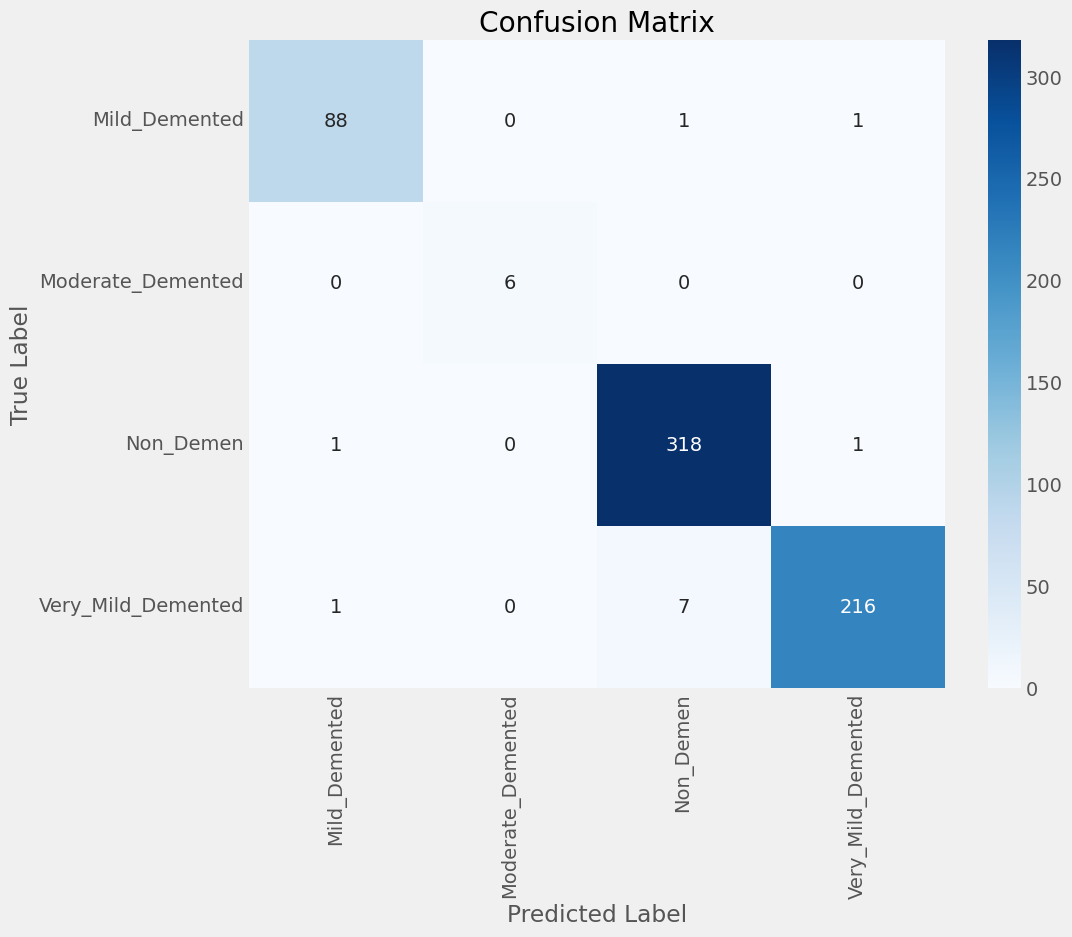

In [34]:
# Get the class names from the generator
class_names = list(test_gen.class_indices.keys())

# Compute the confusion matrix
confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Generate Classification **Report** **bold text**

In [35]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                    precision    recall  f1-score   support

     Mild_Demented       0.98      0.98      0.98        90
 Moderate_Demented       1.00      1.00      1.00         6
         Non_Demen       0.98      0.99      0.98       320
Very_Mild_Demented       0.99      0.96      0.98       224

          accuracy                           0.98       640
         macro avg       0.99      0.98      0.98       640
      weighted avg       0.98      0.98      0.98       640



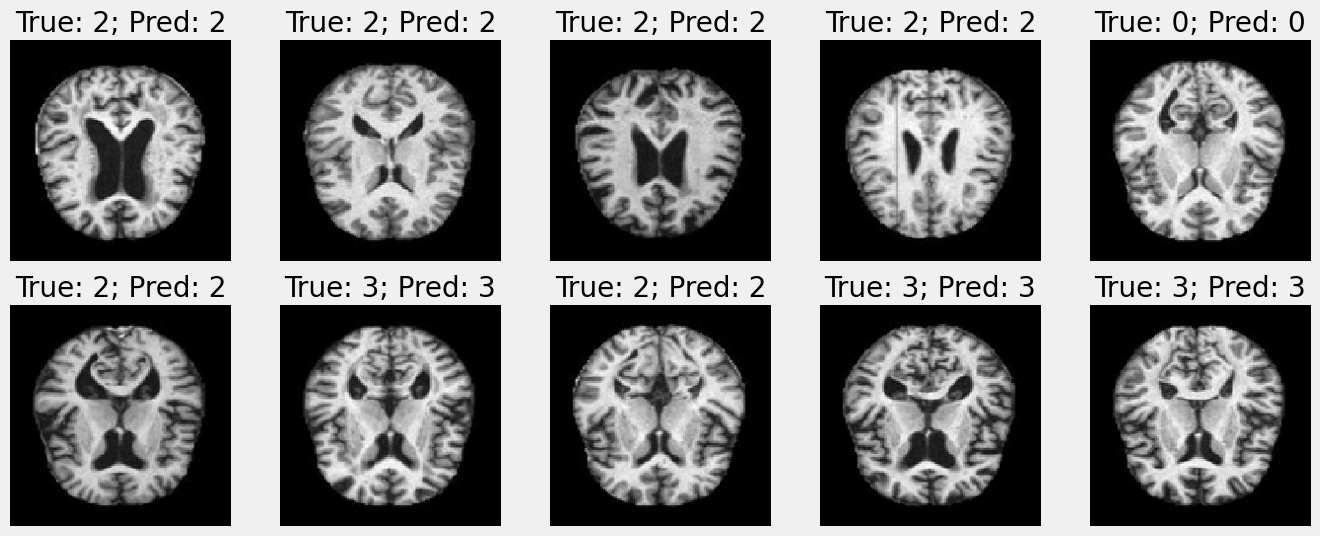

In [36]:
# Function to display images along with their true and predicted labels
def display_images(images, true_labels, predicted_labels, num=10):
    plt.figure(figsize=(15, 6))  # Adjust the figure size to accommodate 10 images
    for i in range(num):
        plt.subplot(2, 5, i + 1)  # Display images in a 2-row, 5-column layout
        plt.imshow(images[i] / 255.0)  # Normalize the image data to the range [0, 1]
        plt.title(f'True: {true_labels[i]}; Pred: {predicted_labels[i]}')  # Show true and predicted labels
        plt.axis('off')  # Hide axis ticks and labels
    plt.show()  # Display the figure

# Get the validation images
val_images = next(iter(valid_gen))[0]  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, y_true_labels, y_pred_labels, num=10)

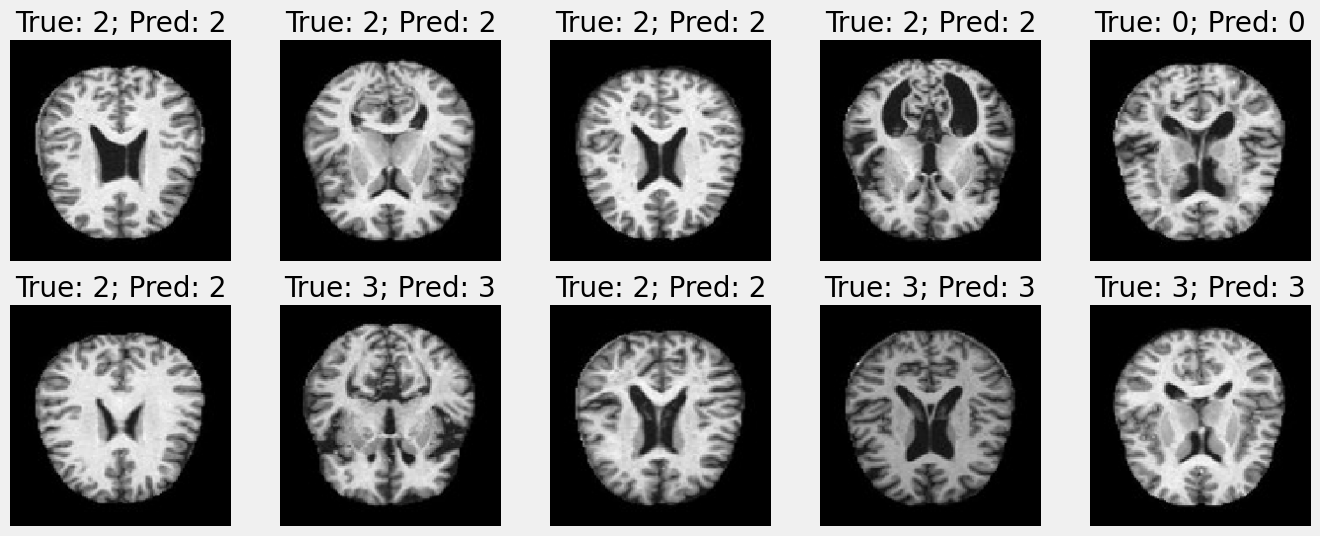

In [37]:
# Get the validation images
val_images = next(iter(valid_gen))[0]  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, y_true_labels, y_pred_labels, num=10)

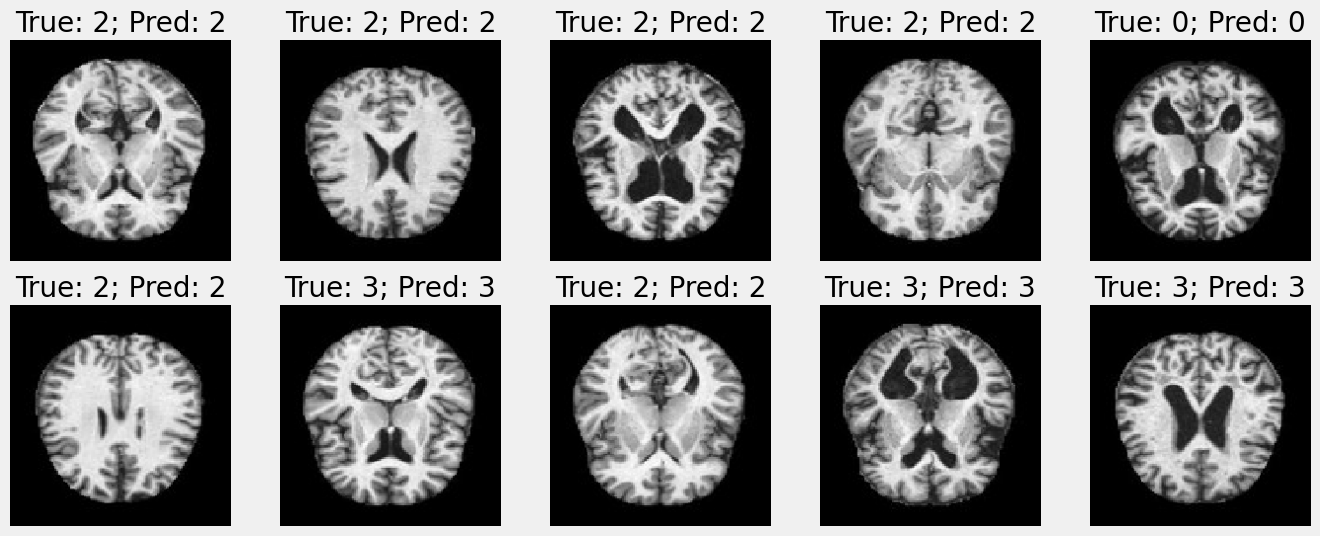

In [38]:
# Get the validation images
val_images = next(iter(test_gen))[0]  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, y_true_labels, y_pred_labels, num=10)

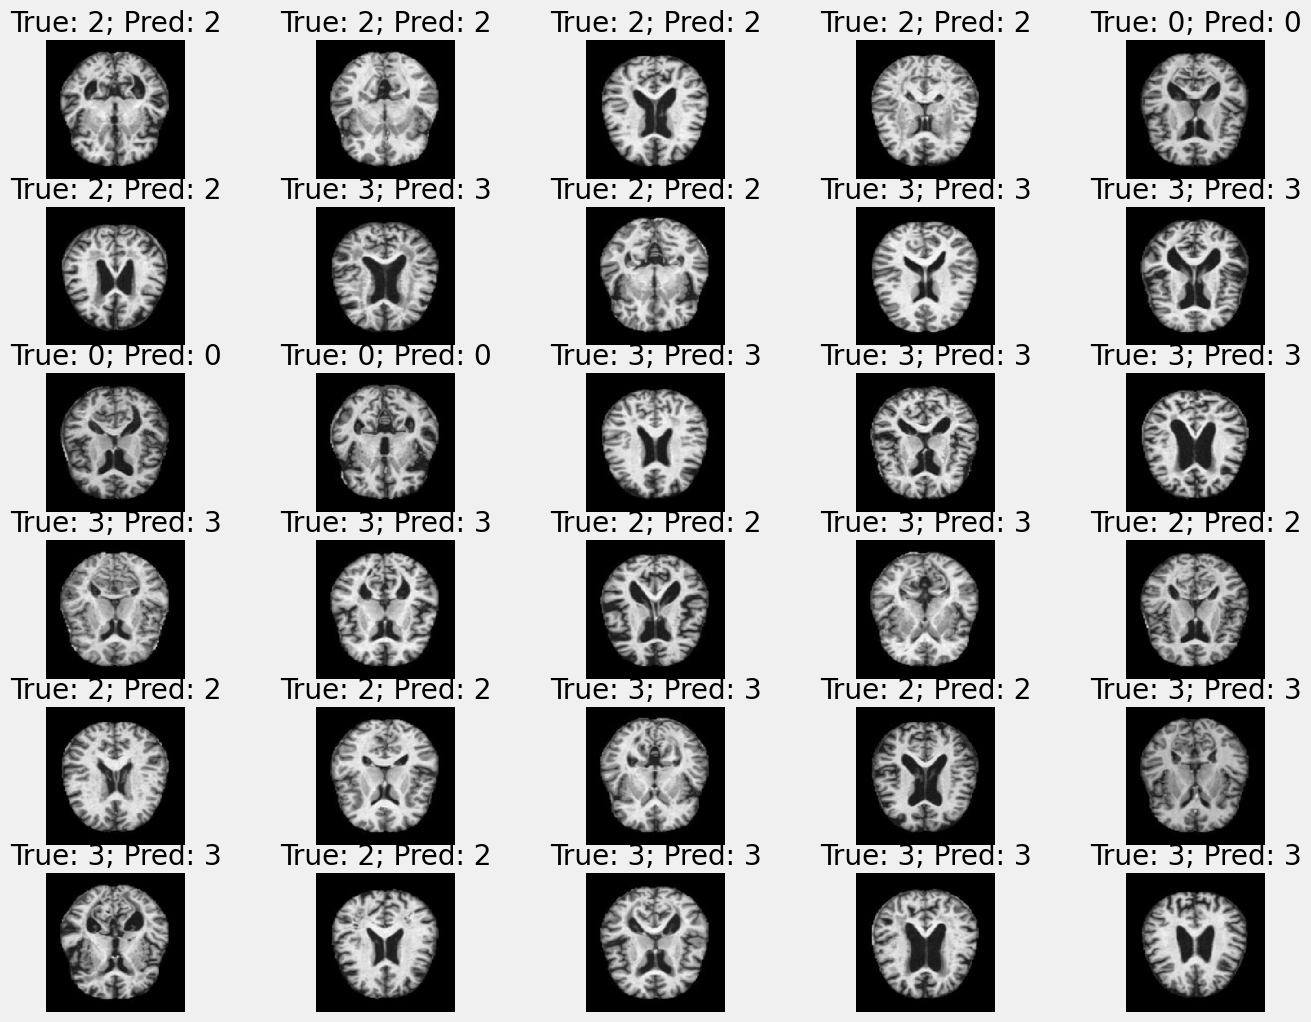

In [40]:
def display_images(images, true_labels, predicted_labels, num=10):
    plt.figure(figsize=(15, 12))  # Adjust the figure size to accommodate 10 images
    for i in range(num):
        plt.subplot(6, 5, i + 1)  # Display images in a 2-row, 5-column layout
        plt.imshow(images[i] / 255.0)  # Normalize the image data to the range [0, 1]
        plt.title(f'True: {true_labels[i]}; Pred: {predicted_labels[i]}')  # Show true and predicted labels
        plt.axis('off')  # Hide axis ticks and labels
    plt.show()  # Display the figure
# Get the validation images
val_images = next(iter(valid_gen))[0]  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, y_true_labels, y_pred_labels, num=30)

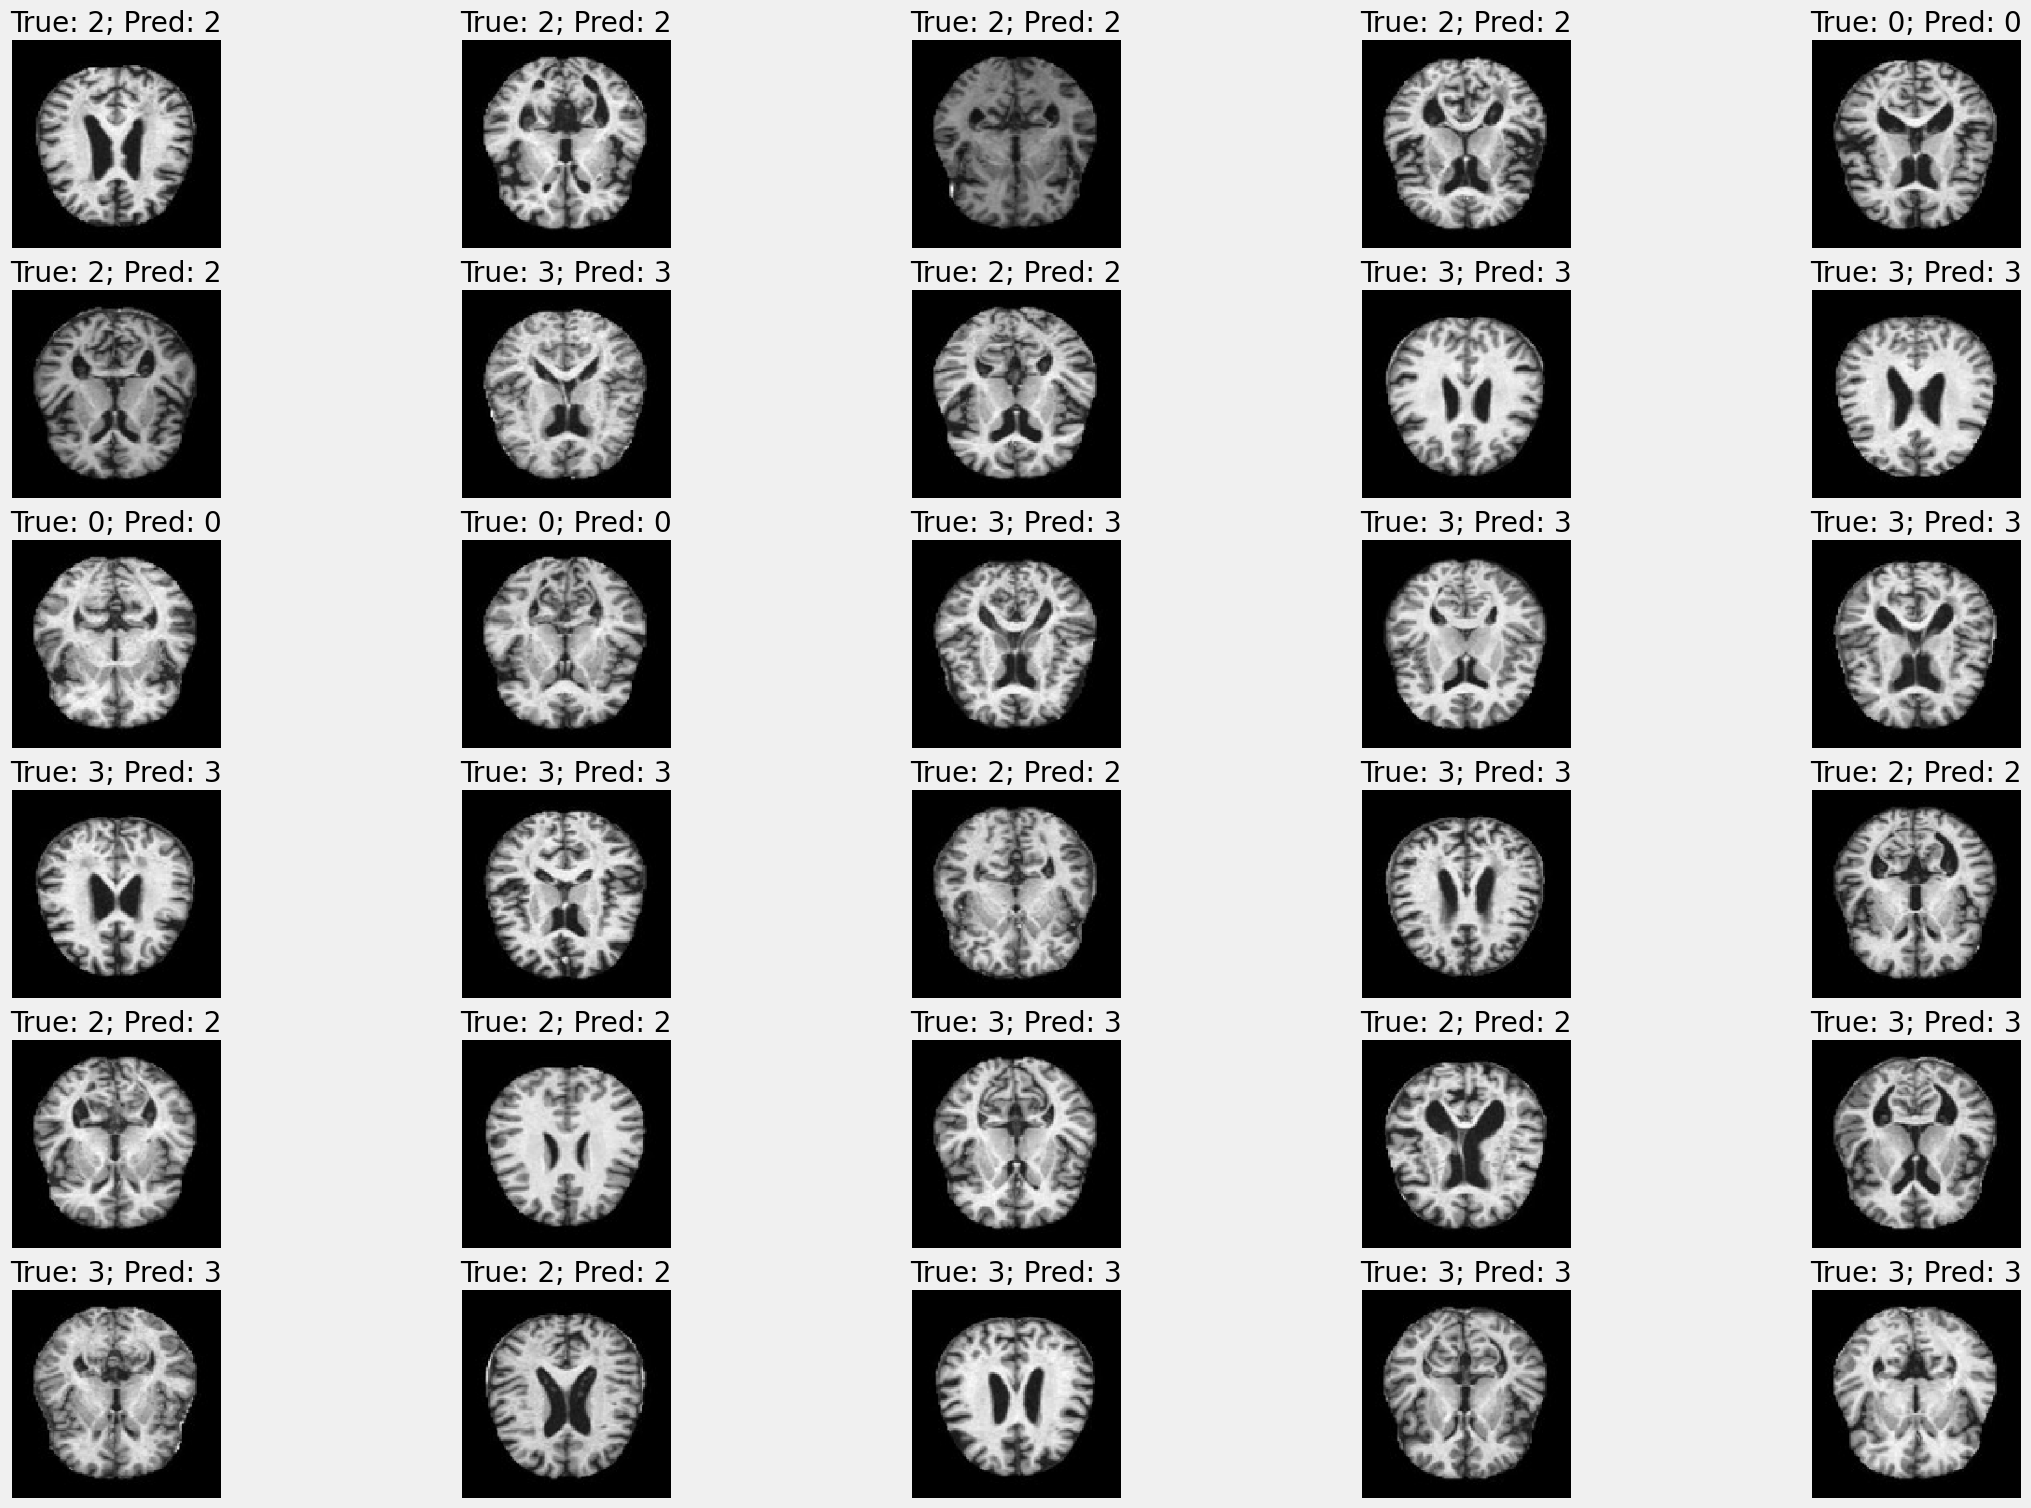

In [41]:
def display_images(images, true_labels, predicted_labels, num=10):
    plt.figure(figsize=(25, 18))  # Adjust the figure size to accommodate 10 images
    for i in range(num):
        plt.subplot(6, 5, i + 1)  # Display images in a 2-row, 5-column layout
        plt.imshow(images[i] / 255.0)  # Normalize the image data to the range [0, 1]
        plt.title(f'True: {true_labels[i]}; Pred: {predicted_labels[i]}')  # Show true and predicted labels
        plt.axis('off')  # Hide axis ticks and labels
    plt.show()  # Display the figure
# Get the validation images
val_images = next(iter(valid_gen))[0]  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, y_true_labels, y_pred_labels, num=30)

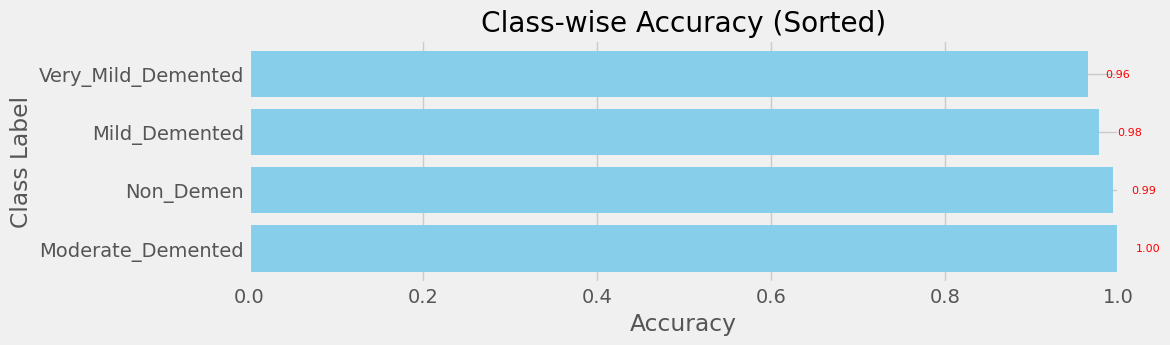

In [42]:
# Calculate accuracy for each class
class_accuracies = np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)

# Sort class accuracies and corresponding class labels
sorted_indices = np.argsort(class_accuracies)[::-1]  # Indices of accuracies in descending order
sorted_class_names = np.array(class_names)[sorted_indices]  # Assign to a single variable
sorted_class_accuracies = class_accuracies[sorted_indices]

# Plot class accuracies
plt.figure(figsize=(10, 3))
bars = plt.barh(sorted_class_names, sorted_class_accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.ylabel('Class Label')
plt.title('Class-wise Accuracy (Sorted)')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1

# Add the accuracy values outside the bars, vertically centered
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.02, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             va='center', ha='left', fontsize=8, color='red')

plt.show()

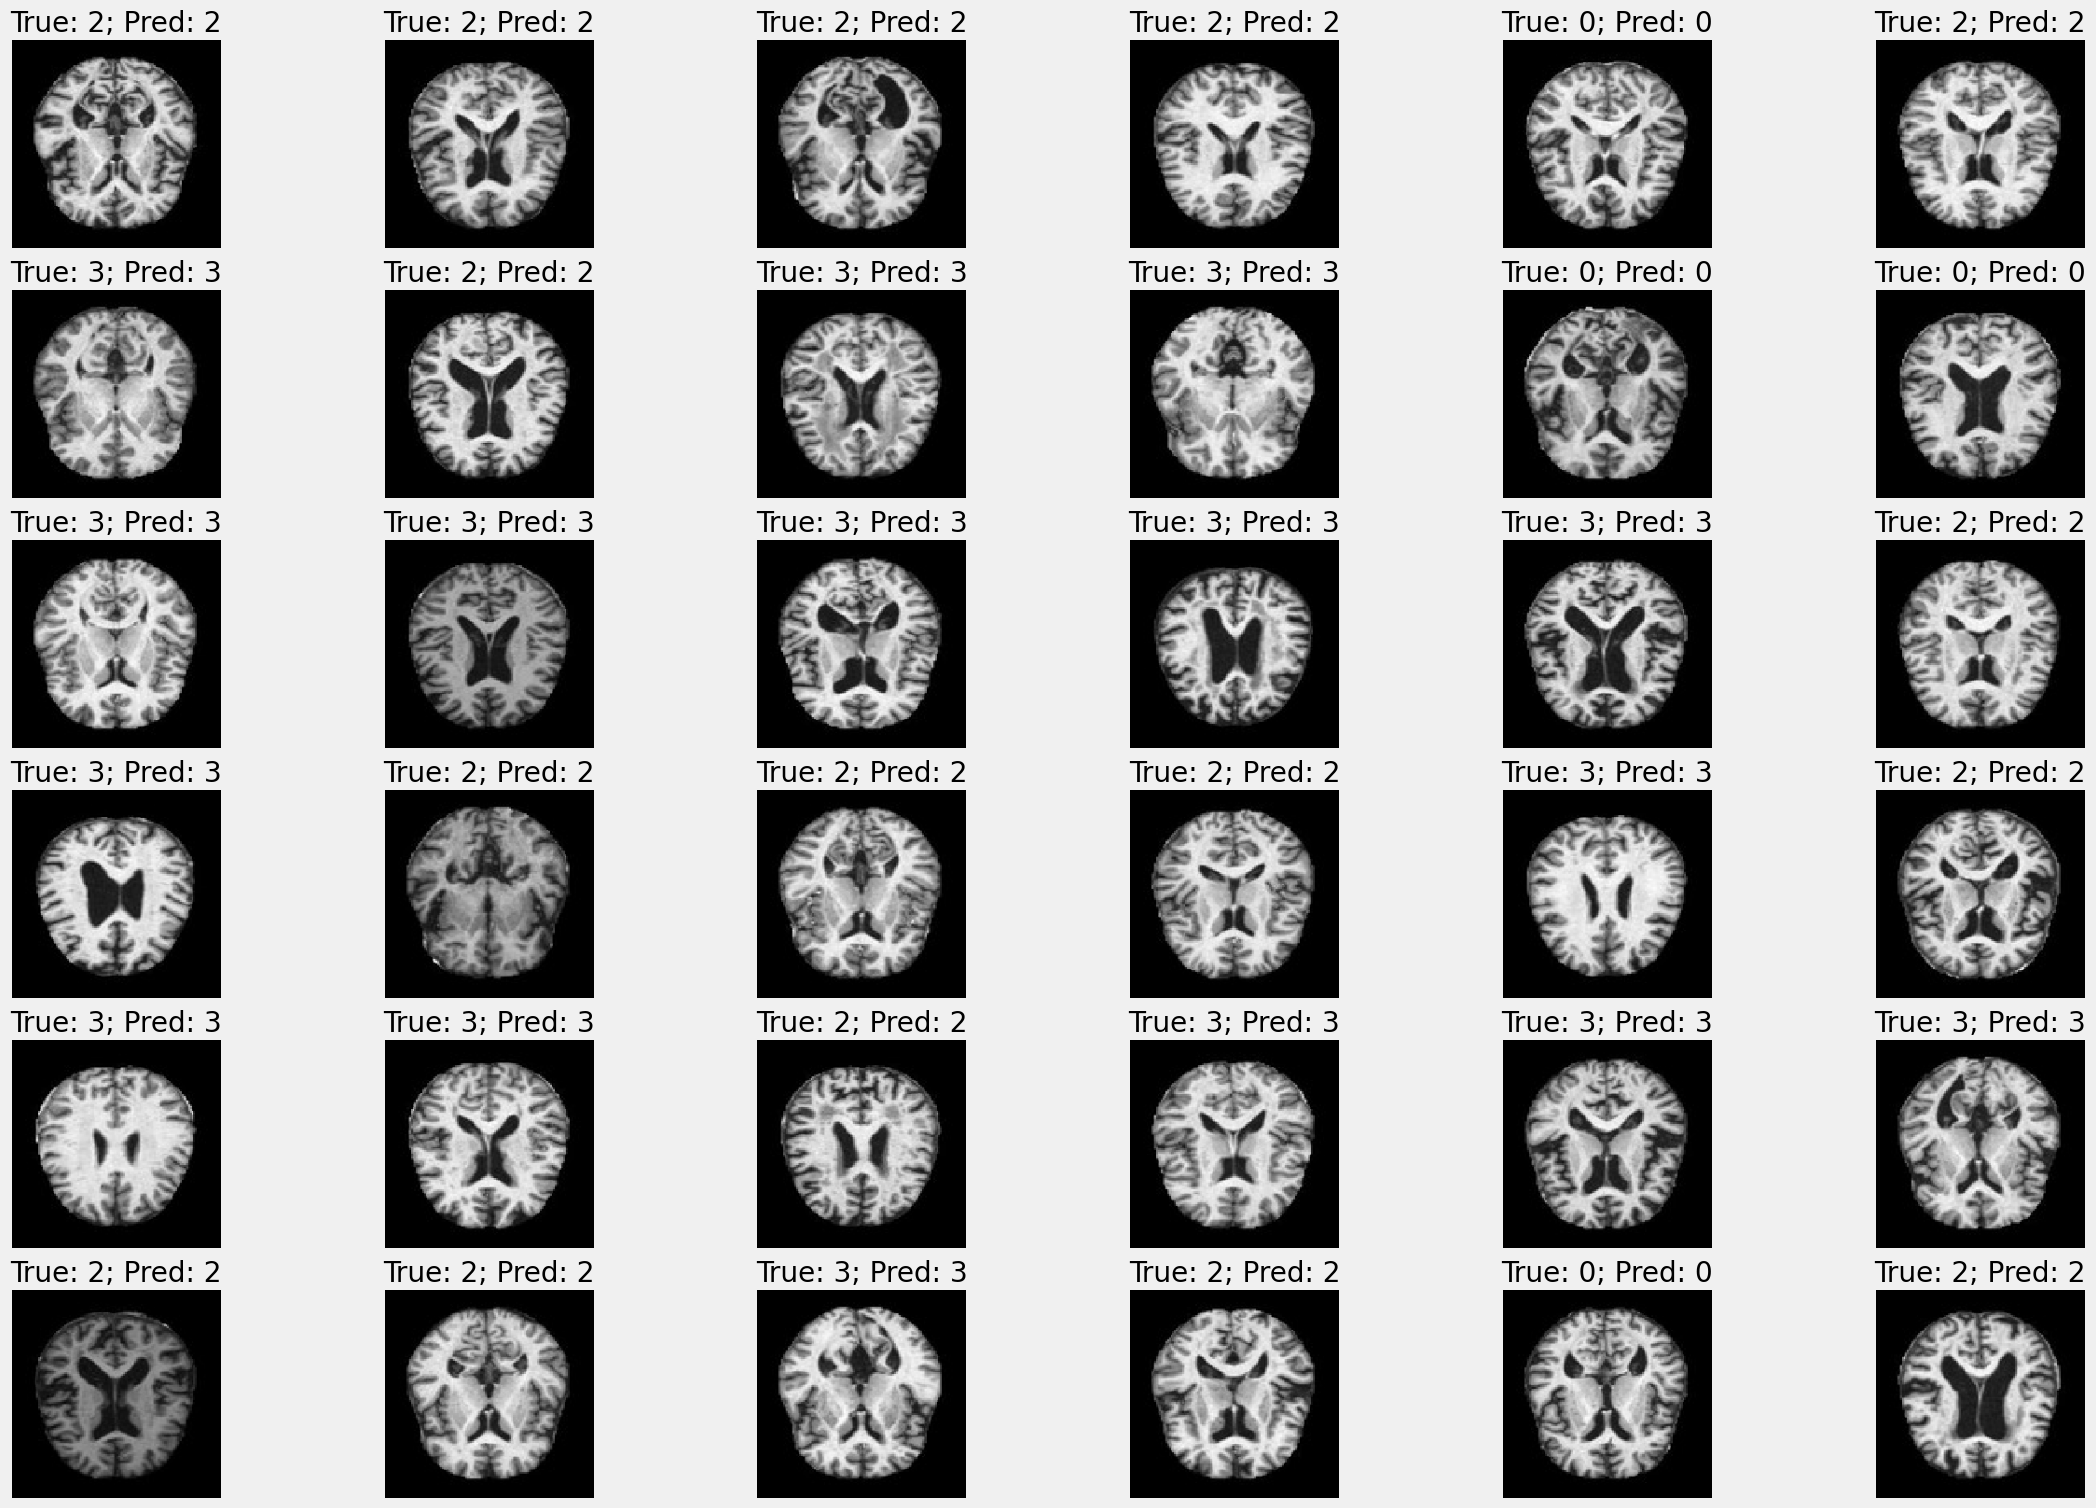

In [48]:
def display_images(images, true_labels, predicted_labels, num=10):
    plt.figure(figsize=(25, 18))  # Adjust the figure size to accommodate 10 images
    for i in range(num):
        plt.subplot(6, 6, i + 1)  # Display images in a 2-row, 5-column layout
        plt.imshow(images[i] / 255.0)  # Normalize the image data to the range [0, 1]
        plt.title(f'True: {true_labels[i]}; Pred: {predicted_labels[i]}')  # Show true and predicted labels
        plt.axis('off')  # Hide axis ticks and labels
    plt.show()  # Display the figure
# Get the validation images
val_images = next(iter(test_gen))[0]  # Assuming validation is an iterable dataset

# Display the first 10 images along with their true and predicted labels
display_images(val_images, y_true_labels, y_pred_labels, num=36)